# 1 Предобработка

### 1.1 Очистка и нормализация текста

In [1]:
import pandas as pd

data = pd.read_csv(
    r'data\raw_dataset.csv',
    encoding='latin-1',
    header=None,
    names=['target', 'id', 'date', 'flag', 'user', 'text']
)

data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


<Axes: >

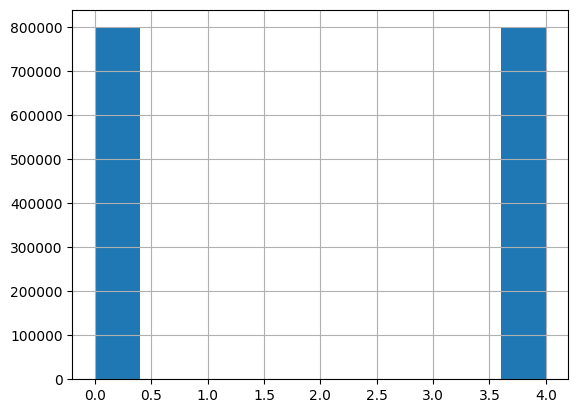

In [2]:
data['target'].hist()

В нижний регистр

In [3]:
text_lower = data['text'].str.lower()

text_lower

0          @switchfoot http://twitpic.com/2y1zl - awww, t...
1          is upset that he can't update his facebook by ...
2          @kenichan i dived many times for the ball. man...
3            my whole body feels itchy and like its on fire 
4          @nationwideclass no, it's not behaving at all....
                                 ...                        
1599995    just woke up. having no school is the best fee...
1599996    thewdb.com - very cool to hear old walt interv...
1599997    are you ready for your mojo makeover? ask me f...
1599998    happy 38th birthday to my boo of alll time!!! ...
1599999    happy #charitytuesday @thenspcc @sparkscharity...
Name: text, Length: 1600000, dtype: object

Удаление ссылок итд + удаление дубликатов

In [4]:
import re

# ссылки и домены
URL_RE = re.compile(r'(https?://\S+|www\.\S+|[a-zA-Z0-9\-]+\.[a-zA-Z]{2,})')
# упоминания
MENTION_RE = re.compile(r'@\w+')
# хэштеги
HASHTAG_RE = re.compile(r'#\w+')

# оставить только латиницу/цифры/пробелы и пунктуацию . , '
ALLOWED_CHARS_RE = re.compile(r"[^a-z0-9\s\.\,']")

# схлопывание повторов:
# 1) буквы: 3+ одинаковых подряд -> 2 (cooool -> coool -> coo)
LETTER_RUNS_RE = re.compile(r'([a-z])\1{2,}')
# 2) пунктуация . , ' : 2+ -> 1 (.... -> .  ,, -> ,  ''' -> ')
PUNCT_RUNS_RE = re.compile(r"([\.\,'])\1+")

def clean(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.lower()

    # убрать ссылки/упоминания/хэштеги
    text = URL_RE.sub(" ", text)
    text = MENTION_RE.sub(" ", text)
    text = HASHTAG_RE.sub(" ", text)

    # убрать все, кроме [a-z0-9] пробелов и . , '
    text = ALLOWED_CHARS_RE.sub(" ", text)

    # схлопнуть длинные буквы (оставить максимум две подряд)
    text = LETTER_RUNS_RE.sub(r"\1\1", text)

    # схлопнуть повторы пунктуации до одной
    text = PUNCT_RUNS_RE.sub(r"\1", text)

    # убрать лишние пробелы
    text = re.sub(r"\s+", " ", text).strip()
    return text



clean_text_lower = text_lower.apply(clean)
clean_text_lower = clean_text_lower.drop_duplicates().reset_index(drop=True)

clean_text_lower

0          aww, that's a bummer. you shoulda got david ca...
1          is upset that he can't update his facebook by ...
2          i dived many times for the ball. managed to sa...
3             my whole body feels itchy and like its on fire
4          no, it's not behaving at all. i'm mad. why am ...
                                 ...                        
1526945    yeah, that does work better than just waiting ...
1526946    just woke up. having no school is the best fee...
1526947                very cool to hear old walt interviews
1526948    are you ready for your mojo makeover ask me fo...
1526949    happy 38th birthday to my boo of all time tupa...
Name: text, Length: 1526950, dtype: object

Статистика

count    19904174.00
mean            4.09
std             2.15
min             1.00
25%             3.00
50%             4.00
75%             5.00
max           112.00
Name: word_len, dtype: float64


<Axes: >

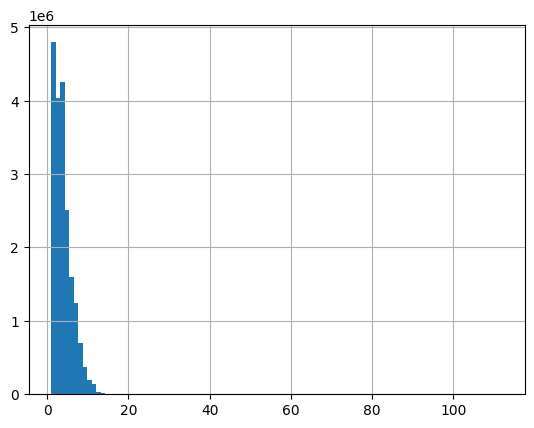

In [5]:
lengths = [len(w) for s in clean_text_lower for w in s.split()]


print(pd.Series(lengths, name="word_len").describe().round(2))
pd.Series(lengths, name="word_len").hist(bins = 100)

### 1.2 Токенизация

In [ ]:
from transformers import AutoTokenizer
import numpy as np


tokenizer = AutoTokenizer.from_pretrained("distilgpt2", use_fast=True)        
tokenizer.add_special_tokens({"pad_token": "<PAD>"})     
EOS = tokenizer.eos_token_id

texts = clean_text_lower.astype(str).tolist()

enc = tokenizer(
    texts,
    add_special_tokens=False,
    padding=False,
    truncation=False          
)

sequences = []
for ids in enc["input_ids"]:
    if not ids:
        continue
    sequences.append(ids + [EOS])

lens = np.array([len(s) for s in sequences])
print(f"Количество твитов: {len(lens)}")
print(f"min/median/mean/max: {lens.min()} / {np.median(lens):.1f} / {lens.mean():.1f} / {lens.max()}")
for q in [50, 75, 90, 95, 99]:
    print(f"p{q}: {int(np.percentile(lens, q))}")

[[707, 86, 11, 326, 338, 257, 275, 31647, 13, 345, 815, 64, 1392, 21970, 1097, 81, 286, 2368, 1110, 284, 466, 340, 13, 288, 50256], [271, 9247, 326, 339, 460, 470, 4296, 465, 23960, 416, 36634, 340, 13, 290, 1244, 3960, 355, 257, 1255, 1524, 1909, 635, 13, 33367, 50256], [72, 288, 1572, 867, 1661, 329, 262, 2613, 13, 5257, 284, 3613, 2026, 262, 1334, 467, 503, 286, 22303, 50256], [1820, 2187, 1767, 5300, 340, 29658, 290, 588, 663, 319, 2046, 50256], [3919, 11, 340, 338, 407, 37722, 379, 477, 13, 1312, 1101, 8805, 13, 1521, 716, 1312, 994, 780, 1312, 460, 470, 766, 345, 477, 625, 612, 13, 50256], [1662, 262, 2187, 5462, 50256], [31227, 257, 16225, 50256], [20342, 890, 640, 645, 766, 3763, 13, 29424, 257, 1643, 837, 8807, 257, 1643, 19462, 837, 1312, 1101, 3734, 5176, 837, 703, 338, 345, 50256], [77, 3008, 484, 1422, 470, 423, 340, 50256], [4188, 502, 38779, 8607, 50256], [16469, 2270, 287, 8631, 1748, 13, 340, 338, 6729, 278, 50256], [72, 655, 302, 41159, 616, 11368, 50256], [72, 3521, 

### 1.3 Разделение на трейн, валидацию и тест

In [10]:
import json
from sklearn.model_selection import train_test_split

train_seqs, temp = train_test_split(sequences, test_size=0.2, random_state=42, shuffle=True)
val_seqs,   test_seqs = train_test_split(temp, test_size=0.5, random_state=42, shuffle=True)


with open("data/train.json", "w", encoding="utf-8") as f:
    json.dump(train_seqs, f, ensure_ascii=False, separators=(",", ":"))
with open("data/val.json", "w", encoding="utf-8") as f:
    json.dump(val_seqs, f, ensure_ascii=False, separators=(",", ":"))
with open("data/test.json", "w", encoding="utf-8") as f:
    json.dump(test_seqs, f, ensure_ascii=False, separators=(",", ":"))

## 2 Обучение модели

In [ ]:
import pandas as pd
import ast
import os
from tqdm import tqdm
import numpy as np
import torch
import json
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from transformers import AutoTokenizer

from src.dataset import NextTokenDataset
from src.model import RNNAutocompletion
from src.utils import free_gen_rougeL


TRAIN_DATA_PATH = r"data\train.json"
VALID_DATA_PATH = r"data\val.json"
EXP_NAME = "exp1"
CHUNK_LEN = 32
STRIDE = CHUNK_LEN
EPOCHS = 301
BATCH_SIZE = 256
LR = 2e-3
DIM = 256
NUM_LAYERS = 2
DROPOUT = 0.3

EVAL_EVERY = 1
EVAL_K_LIST = (1, 7, 21, 28)
REF_MAX_TOKENS = 32
GEN_MAX_NEW_TOKENS = REF_MAX_TOKENS
SAMPLES_PER_K = 10


with open(TRAIN_DATA_PATH, "r", encoding="utf-8") as f:
    train_sequences = json.load(f)  

with open(VALID_DATA_PATH, "r", encoding="utf-8") as f:
    valid_sequences = json.load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_type = "cuda" if device.type == "cuda" else "cpu"
print(f"device: {device}")

tokenizer = AutoTokenizer.from_pretrained("distilgpt2", use_fast=True)
tokenizer.add_special_tokens({"pad_token": "<PAD>"})
pad_token_id = tokenizer.pad_token_id
eos_token_id = tokenizer.eos_token_id
vocab_size = len(tokenizer)

dataset_train = NextTokenDataset(train_sequences, chunk_length=CHUNK_LEN, stride=STRIDE, offset=0)
dataset_val = NextTokenDataset(valid_sequences, chunk_length=CHUNK_LEN, stride=STRIDE, offset=0)

dl_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
dl_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

model = RNNAutocompletion(
    vocab_size=vocab_size,
    pad_token_id=pad_token_id,
    eos_token_id=eos_token_id,
    dim=DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
    ).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
scaler = torch.amp.GradScaler(device=device_type, enabled=(device_type == "cuda"))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=2,
    min_lr=1e-4,
)

save_path = os.path.join("exp", EXP_NAME)
os.makedirs(f"{save_path}/weights", exist_ok=True)
writer = SummaryWriter(log_dir=f"{save_path}/logs")

best_val_loss = float("inf")
train_step = 0
dataset_val.set_offset(0)

for epoch in range(EPOCHS):

    dataset_train.set_offset()
    model.train()
    train_losses = []

    for batch in tqdm(dl_train, desc=f"Epoch {epoch}", unit="batch"):
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type=device_type, enabled=(device_type == "cuda")):
            logits, _ = model(input_ids)
            loss = criterion(logits.view(-1, logits.size(-1)), labels.view(-1))

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)                                
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 
        scaler.step(optimizer)                                    
        scaler.update()

        train_losses.append(loss.item())
        writer.add_scalar("Loss/train_step", loss.item(), train_step)
        train_step += 1

    train_loss = np.mean(train_losses)
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("LR", optimizer.param_groups[0]["lr"], epoch)

    model.eval()
    val_losses = []
    val_last_correct1  = 0
    val_last_correct5 = 0
    val_last_total = 0

    with torch.no_grad(), torch.amp.autocast(device_type=device_type, enabled=(device_type == "cuda")):
        for batch in dl_val:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)

            logits, _ = model(input_ids)
            loss = criterion(logits.view(-1, logits.size(-1)), labels.view(-1))
            val_losses.append(loss.item())

            last_logits = logits[:, -1, :]
            last_labels = labels[:, -1]

            pred1 = last_logits.argmax(dim=-1) 
            val_last_correct1 += (pred1 == last_labels).sum().item()

            top5 = last_logits.topk(5, dim=-1).indices
            val_last_correct5 += (top5 == last_labels.unsqueeze(-1)).any(dim=-1).sum().item()

            val_last_total += last_labels.numel()

    val_loss = np.mean(val_losses)
    val_ppl = np.exp(val_loss)
    val_last_acc1 = val_last_correct1 / val_last_total
    val_last_acc5 = val_last_correct5 / val_last_total

    writer.add_scalar("Loss/valid", val_loss, epoch)
    writer.add_scalar("Perplexity/valid", val_ppl, epoch)
    writer.add_scalar("Acc/valid_last@1", val_last_acc1, epoch)
    writer.add_scalar("Acc/valid_last@5", val_last_acc5, epoch)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f"{save_path}/weights/best.pt")

    scheduler.step(val_loss)

    print(f"train loss: {train_loss:.4f} | valid loss: {val_loss:.4f} | ppl: {val_ppl:.2f} "f"| acc@1: {val_last_acc1:.4f} | acc@5: {val_last_acc5:.4f}")

    if (epoch + 1) % EVAL_EVERY == 0:
        model.eval()
        out = free_gen_rougeL(
            msgs=dataset_val.msgs,
            model=model,
            tokenizer=tokenizer,
            eos_id=eos_token_id,
            k_list=EVAL_K_LIST,
            ref_max_tokens=REF_MAX_TOKENS,
            gen_max_new_tokens=GEN_MAX_NEW_TOKENS,
            batch_size=BATCH_SIZE,
            device=device_type,
            samples_per_k=SAMPLES_PER_K,
        )

        for k, d in out["metrics"].items():
            writer.add_scalar(f"ROUGE/rougeL_K{k}", d["rougeL"], epoch)

        for k, samples in out["samples"].items():
            if not samples:
                continue

            print(f"\n[Примеры размер контекста = {k}]")

            for j, s in enumerate(samples, 1):
                ctx  = s["context_text"]
                ref  = s["reference_text"]
                pred = s["prediction_text"]
                print(f"--- sample {j} (idx={s['index']}) ---")
                print(f"{ctx} | {ref}")
                print(f"{ctx} | {pred}\n")

            tb_blocks = []
            for j, s in enumerate(samples, 1):
                ctx  = s["context_text"]
                ref  = s["reference_text"]
                pred = s["prediction_text"]
                tb_blocks.append(
                    "```\n"
                    f"{ctx} | {ref}\n"
                    f"{ctx} | {pred}\n"
                    "```"
                )
            writer.add_text(f"ROUGE/samples_K{k}", "\n\n".join(tb_blocks), epoch)

        text = " | ".join([f"K={k}: {d['rougeL']:.4f} (n={d['count']})" for k, d in out["metrics"].items()])
        print(f"[ROUGE-L@epoch {epoch}] {text}")

torch.save(model.state_dict(), f"{save_path}/weights/last.pt")
writer.close()

device: cuda


Epoch 0: 100%|██████████| 2576/2576 [03:53<00:00, 11.02batch/s]


train loss: 6.1275 | valid loss: 5.1334 | ppl: 169.60 | acc@1: 0.1933 | acc@5: 0.3832

[Примеры размер контекста = 1]
--- sample 1 (idx=56912) ---
dam | n i left my phone charger in the car i may never ever see it again
dam | n. i'm so sad.

--- sample 2 (idx=67434) ---
to |  cfa friends check grades in crs module to see tentative results. i didn't get my majors section. oh god.
to |  the new moon trailer.

--- sample 3 (idx=92326) ---
h | ahaha ps i favorited this tweet lol
h | aha. i'm so sad

--- sample 4 (idx=97382) ---
just |  called jessieo to wish her happy 5th birthday sad that im not there, but had a good say out with her on thursday.
just |  got home from the beach.

--- sample 5 (idx=135034) ---
so |  i was just watching the news, knowing they would be talking about the concert today, i was right, and they said it would be really hot
so | o i'm so sad.

--- sample 6 (idx=25660) ---
can | 't believe my vaca is coming to an end already. not that home is a hardship, but man it 

Epoch 1: 100%|██████████| 2576/2576 [04:05<00:00, 10.51batch/s]


train loss: 5.1195 | valid loss: 4.9573 | ppl: 142.20 | acc@1: 0.2044 | acc@5: 0.4001

[Примеры размер контекста = 1]
--- sample 1 (idx=50573) ---
45 |  minutes to an hour max. depending on when it was last found amp whether we think we've exhausted all possibilities. boo dnf's
45 | .

--- sample 2 (idx=59295) ---
new |  jerseys flags hats i think i'll get a laker's poster to put in my window on hollywood blvd. .
new |  moon trailer.

--- sample 3 (idx=9246) ---
 hour |  mondays is surely a test of my dedication. not good. finished reading a book last night, the protagenist dies, i was very sad
 hour | .

--- sample 4 (idx=5933) ---
yeah |  its just her 12 month check up. but she has to get lots of shots sorry i'ma softee lol
yeah | , i'm soo tired. i'm so tired.

--- sample 5 (idx=111034) ---
starting |  p90x. goodbye cheetos, brisket, and jimmy dean. hello carrots, turkey breast, and morningstar.
starting |  to work.

--- sample 6 (idx=94053) ---
got |  my permit today
got |  a new p

Epoch 2: 100%|██████████| 2576/2576 [04:15<00:00, 10.07batch/s]


train loss: 4.9844 | valid loss: 4.8622 | ppl: 129.31 | acc@1: 0.2100 | acc@5: 0.4102

[Примеры размер контекста = 1]
--- sample 1 (idx=82066) ---
tic | os, pool party at hotel, big straws, bestest people perfect
tic | .

--- sample 2 (idx=85333) ---
just |  finished my bag of de lujo from now who do i order my next bag from. come on and . dance off
just |  got home from the gym. i'm soo tired. i'm soo tired.

--- sample 3 (idx=30650) ---
i |  can't get any information about the 30 day challenge my headset is not working
i |  have a headache. i'm soo tired.

--- sample 4 (idx=32948) ---
n | j modeling affair, club quest tonight. . right after i nap
n |  i'm soo tired. i'm soo tired.

--- sample 5 (idx=119272) ---
bye | bye ansley i had an amazing weekend with youu see you in august babe ily too xcaroxx
bye | 

--- sample 6 (idx=46635) ---
aw | w at least you were honest with her.
aw | w i'm sorry i'm not sure if i can't wait to see you in the morning

--- sample 7 (idx=42673) ---
w | o

Epoch 3: 100%|██████████| 2576/2576 [04:20<00:00,  9.89batch/s]


train loss: 4.9016 | valid loss: 4.8028 | ppl: 121.85 | acc@1: 0.2155 | acc@5: 0.4151

[Примеры размер контекста = 1]
--- sample 1 (idx=32840) ---
you | 've sent more than enough already.
you |  are the best

--- sample 2 (idx=54326) ---
and |  they have a concert next thursday
and |  i'm not sure if i can't get it

--- sample 3 (idx=139986) ---
y | ep see y'all tomorrow
y | 

--- sample 4 (idx=105747) ---
i | ow fest was incredible.cant wait for next year already
i | 'm soo tired.

--- sample 5 (idx=1095) ---
ok |  beloved twitter friends,i'm done for the night amp will excuse myself this ,coz i have a busy day ahead but i love u all
ok | , i'm not sure if i can get a new one

--- sample 6 (idx=9571) ---
there |  is free internet on the notebooks sonystyle, the curve
there | 's a new one.

--- sample 7 (idx=84022) ---
gger | , walker, wesche, marie, amp some guy named akron then we visited tokio, bria, etc. brewer's
gger | .

--- sample 8 (idx=46110) ---
can |  no longer move my finge

Epoch 4:  69%|██████▉   | 1771/2576 [03:00<01:22,  9.80batch/s]


KeyboardInterrupt: 

## Сравнение обученной модели и distilgpt2 на тестовой выборке

In [ ]:
import json
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
from src.dataset import NextTokenDataset
from src.model import RNNAutocompletion
from src.utils import free_gen_rougeL, free_gen_rougeL_distilgpt2

TEST_DATA_PATH = r"data\test.json"
BEST_WEIGHTS = r"exp\exp1\weights\best.pt"

CHUNK_LEN = 32
STRIDE = CHUNK_LEN
BATCH_SIZE = 256

K_LIST = (1, 7, 21, 28)
REF_MAX_TOKENS = 32
GEN_MAX_NEW_TOKENS = REF_MAX_TOKENS
SAMPLES_PER_K = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_type = device.type
print(f"device: {device}")

tokenizer = AutoTokenizer.from_pretrained("distilgpt2", use_fast=True)
tokenizer.add_special_tokens({"pad_token": "<PAD>"})
pad_token_id = tokenizer.pad_token_id
eos_token_id = tokenizer.eos_token_id
vocab_size = len(tokenizer)

with open(TEST_DATA_PATH, "r", encoding="utf-8") as f:
    test_sequences = json.load(f)

ds_test = NextTokenDataset(test_sequences, chunk_length=CHUNK_LEN, stride=STRIDE, offset=0)
test_msgs = [m.tolist() if isinstance(m, torch.Tensor) else list(m) for m in ds_test.msgs]

DIM, NUM_LAYERS, DROPOUT = 256, 2, 0.3
rnn_model = RNNAutocompletion(
    vocab_size=vocab_size,
    pad_token_id=pad_token_id,
    eos_token_id=eos_token_id,
    dim=DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
).to(device).eval()
rnn_model.load_state_dict(torch.load(BEST_WEIGHTS, map_location=device))

out_rnn = free_gen_rougeL(
    msgs=test_msgs,
    model=rnn_model,
    tokenizer=tokenizer,
    eos_id=eos_token_id,
    k_list=K_LIST,
    ref_max_tokens=REF_MAX_TOKENS,
    gen_max_new_tokens=GEN_MAX_NEW_TOKENS,
    batch_size=BATCH_SIZE,
    device=device_type,
    samples_per_k=SAMPLES_PER_K,
)

distilgpt2_model = AutoModelForCausalLM.from_pretrained("distilgpt2")
distilgpt2_model.resize_token_embeddings(len(tokenizer))
distilgpt2_model.config.pad_token_id = tokenizer.pad_token_id
distilgpt2_model.config.eos_token_id = eos_token_id
distilgpt2_model = distilgpt2_model.to(device).eval()

vocab_n = distilgpt2_model.get_input_embeddings().num_embeddings

out_distilgpt2 = free_gen_rougeL_distilgpt2(
    msgs=test_msgs,
    model=distilgpt2_model,
    tokenizer=tokenizer,
    eos_id=eos_token_id,
    k_list=K_LIST,
    ref_max_tokens=REF_MAX_TOKENS,
    gen_max_new_tokens=GEN_MAX_NEW_TOKENS,
    batch_size=BATCH_SIZE,
    device=device_type,
    samples_per_k=SAMPLES_PER_K,
)

def print_perf(tag, out):
    p = out["perf"]
    print(f"\n{tag} tokens/s: {p['tokens_per_sec']:.1f} "
          f"({p['total_gen_tokens']} tok, {p['total_elapsed_sec']:.2f}s)")
    for k, d in p["by_k"].items():
        print(f"  K={k}: {d['tokens_per_sec']:.1f} ({d['gen_tokens']} tok, {d['elapsed_sec']:.2f}s)")

print_perf("rnn", out_rnn)
print_perf("distilgpt2", out_distilgpt2)

rows = []
for k in K_LIST:
    mr = out_rnn["metrics"].get(k, {"rougeL": 0.0, "count": 0})
    mh = out_distilgpt2["metrics"].get(k, {"rougeL": 0.0, "count": 0})
    rows.append({
        "K": k,
        "RNN_rougeL": mr["rougeL"],
        "RNN_count": mr["count"],
        "distilgpt2_rougeL": mh["rougeL"],
        "distilgpt2_count": mh["count"],
        "delta_distilgpt2_minus_RNN": mh["rougeL"] - mr["rougeL"],
    })
df = pd.DataFrame(rows).set_index("K")
print("\nROUGE-L (test):")
print(df.to_string(float_format=lambda x: f"{x:.4f}"))

samples_path = "samples_test.txt"
with open(samples_path, "w", encoding="utf-8") as f:
    for name, out in [("rnn", out_rnn), ("distilgpt2", out_distilgpt2)]:
        print(f"\n{name} samples")
        f.write(f"{name} samples\n")
        for k in K_LIST:
            samples = out["samples"].get(k, [])
            if not samples:
                continue
            print(f"\nK={k}")
            f.write(f"\nK={k}\n")
            for s in samples:
                ctx = s["context_text"]
                ref = s["reference_text"]
                pred = s["prediction_text"]
                print(f"{ctx} | {ref}")
                print(f"{ctx} | {pred}\n")
                f.write(f"{ctx} | {ref}\n")
                f.write(f"{ctx} | {pred}\n\n")
print(f"\nsamples saved to: {samples_path}")


device: cuda
